In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd 

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


### Connect to train and test folders

In [ ]:
TRAIN_ROOT = "/content/gdrive/MyDrive/Opensource_data/MRI_data/Training"
TEST_ROOT = "/content/gdrive/MyDrive/Opensource_data/MRI_data/Testing"
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)

### Create the classification images model (VGG16 in our case with transfered knowlegde)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True) 

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features 
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model = CNNModel()
model.to(device)
model


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

CNNModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

### Prepare data and create loaders

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)



batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

### Train the model

In [ ]:
# Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 20

# Iterate x epochs over the train data
for epoch in range(epochs):  
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss)

tensor(1.4836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3814, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2838, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1668, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2790, device='cuda:0', grad_fn=

### Inspect predictions

In [ ]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model(inputs).max(1).indices.detach().cpu().numpy()
comparison = pd.DataFrame()
print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
comparison["labels"] = labels

comparison["outputs"] = outputs
comparison

Batch accuracy:  0.8125


,labels,outputs
0,2,2
1,0,1
2,3,3
3,1,1
4,1,1
5,2,2
6,3,3
7,2,2
8,0,2
9,2,2


### Apply LRP for VGG16 in 4 steps (could be 5 optionally)

#### Create helping functions

In [ ]:
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']): 
        if isinstance(layer, nn.Linear): 
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

#### Apply steps

In [ ]:
def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations
    
    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)
            
            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9
            
            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data                                     
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward(); 
            c = activations[layer].grad       
            # Assign new relevance values           
            relevances[layer] = (activations[layer]*c).data                          
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

#### Calculate relevances for first image in the test batch

In [ ]:
image_id = 3
image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()), 
                                                (0, 1))

#### Show relevances and plots

Groundtruth for this image:  pituitary_tumor


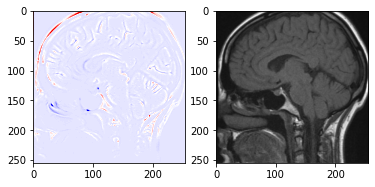

In [ ]:
pred_label = list(test_dataset.class_to_idx.keys())[
             list(test_dataset.class_to_idx.values())
            .index(labels[image_id])]
if outputs[image_id] == labels[image_id]:
    print("Groundtruth for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(image_relevances[:,:,0], cmap="seismic")
    plt.subplot(1,2,2)
    plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
    plt.show()
else:
    print("This image is not classified correctly.")


Image 0
Groundtruth for this image:  no_tumor


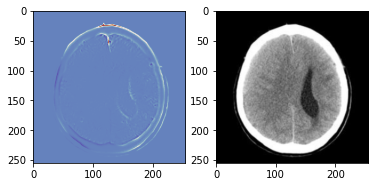

Image 1
This image is not classified correctly.
Image 2
Groundtruth for this image:  pituitary_tumor


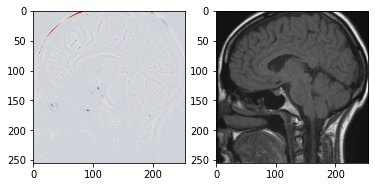

Image 3
Groundtruth for this image:  meningioma_tumor


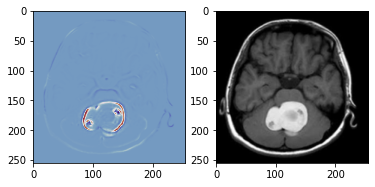

Image 4
Groundtruth for this image:  meningioma_tumor


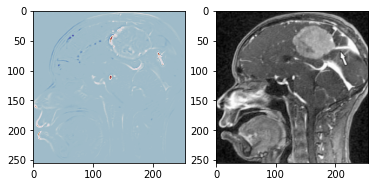

Image 5
Groundtruth for this image:  no_tumor


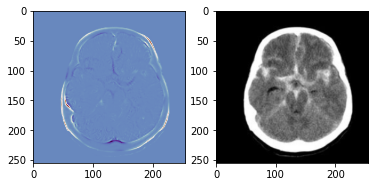

Image 6
Groundtruth for this image:  pituitary_tumor


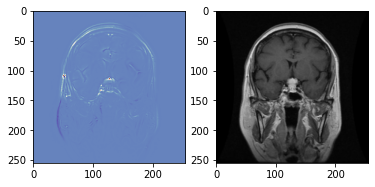

Image 7
Groundtruth for this image:  no_tumor


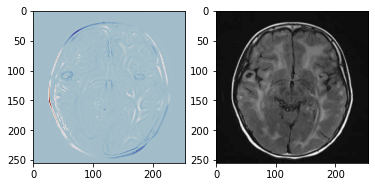

Image 8
This image is not classified correctly.
Image 9
Groundtruth for this image:  no_tumor


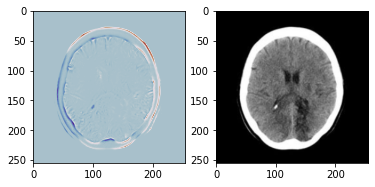

Image 10
Groundtruth for this image:  meningioma_tumor


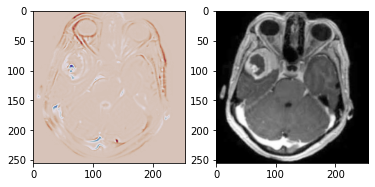

Image 11
Groundtruth for this image:  no_tumor


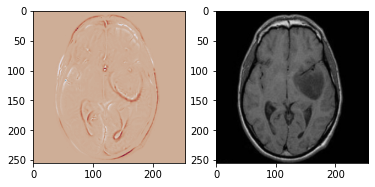

Image 12
Groundtruth for this image:  pituitary_tumor


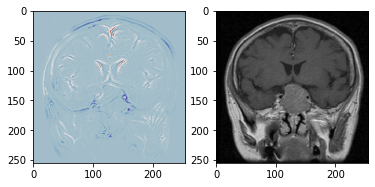

Image 13
Groundtruth for this image:  meningioma_tumor


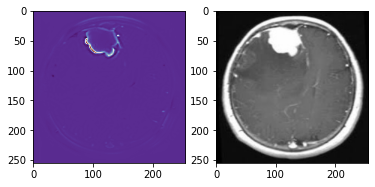

Image 14
This image is not classified correctly.
Image 15
This image is not classified correctly.
Image 16
Groundtruth for this image:  no_tumor


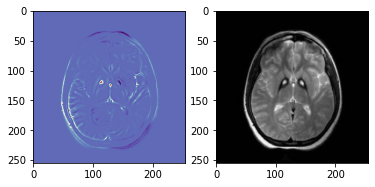

Image 17
This image is not classified correctly.
Image 18
This image is not classified correctly.
Image 19
Groundtruth for this image:  no_tumor


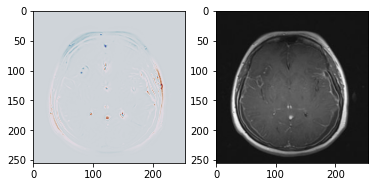

Image 20
Groundtruth for this image:  no_tumor


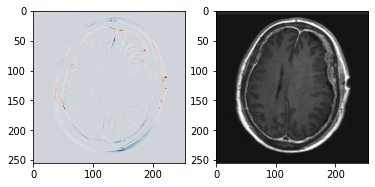

Image 21
Groundtruth for this image:  no_tumor


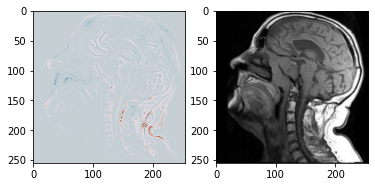

Image 22
Groundtruth for this image:  no_tumor


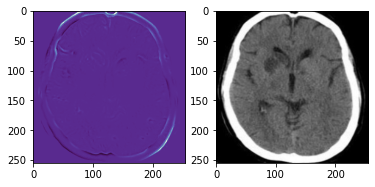

Image 23
Groundtruth for this image:  no_tumor


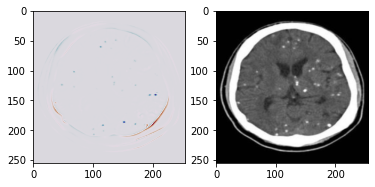

Image 24
Groundtruth for this image:  meningioma_tumor


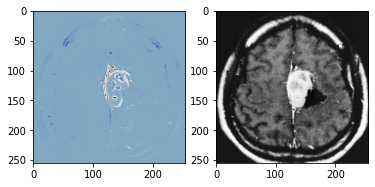

Image 25
Groundtruth for this image:  pituitary_tumor


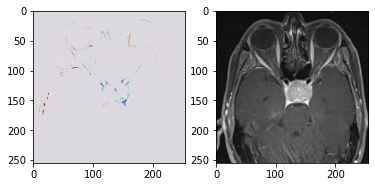

Image 26
Groundtruth for this image:  no_tumor


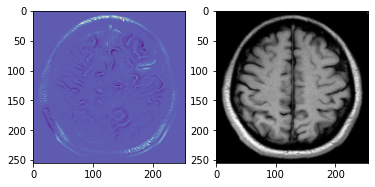

Image 27
Groundtruth for this image:  no_tumor


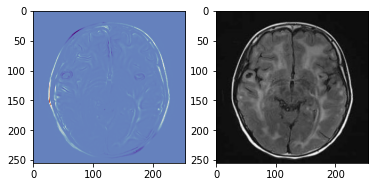

Image 28
Groundtruth for this image:  no_tumor


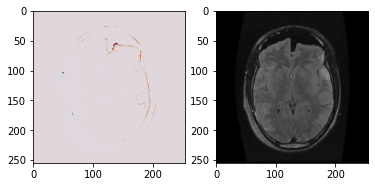

Image 29
Groundtruth for this image:  no_tumor


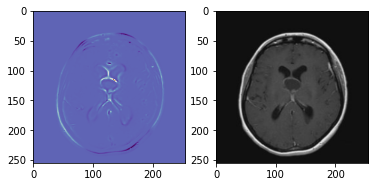

Image 30
Groundtruth for this image:  pituitary_tumor


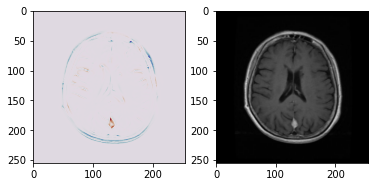

Image 31
Groundtruth for this image:  no_tumor


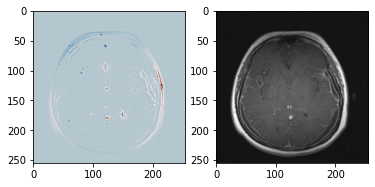

In [ ]:
#### Itteration for all images in the batch
for image_id in range(0,32):
  image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
  image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
  image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                  image_relevances.max()), 
                                                  (0, 1))
  pred_label = list(test_dataset.class_to_idx.keys())[
              list(test_dataset.class_to_idx.values())
              .index(labels[image_id])]
  print("Image {}".format(image_id))
  if outputs[image_id] == labels[image_id]:
      print("Groundtruth for this image: ", pred_label)

      # Plot images next to each other
      plt.axis('off')
      plt.subplot(1,2,1)
      plt.imshow(image_relevances[:,:,0], cmap="twilight_shifted")
      plt.subplot(1,2,2)
      plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
      plt.show()
  else:
      print("This image is not classified correctly.")